In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from pdb import set_trace as breakpoint
from time import time

import numpy as np
import matplotlib.pyplot as plt
import h5py

from datasets.generators1d import * 
from models.utils import pbar, tensor_diff, tensor_roll

In [2]:
OMEGA = 1.215e15
MU0 = 4 * np.pi * 10**-7
EPSILON0 =  8.854187817620e-12 
SCALE = 1e-15
C = 299792458.0
L0 = 1e-6
PIXEL_SIZE = 0.05 * L0
wavelength = 2 * np.pi * C / OMEGA

## Cavity experiments

In [79]:
# perms = np.ones(65)
perms = perm_alternating_layers(s=65)
epsilons, src_x, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perms, omega=OMEGA_1550)

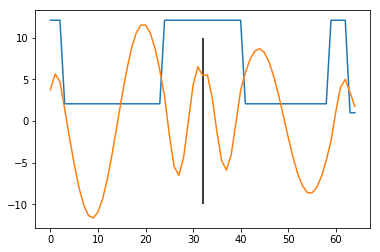

In [80]:
plt.plot(epsilons[16:-16])
plt.plot(np.imag(Ez)[16:-16], label="$E_\mathrm{true}$")
plt.vlines(src_x, -10, 10)
plt.show()


In [83]:
a = torch.tensor(np.imag(Ez)[16:-16])
roll=tensor_roll(a, 1)
dif = tensor_diff(a, n=2, cyclic=True)

zero = torch.tensor([0.0]).double()
# dif2 = torch.cat([zero,tensor_diff(a, n=2, padding=None), zero],dim=-1)
dif2=tensor_diff(a, n=2, padding=True)

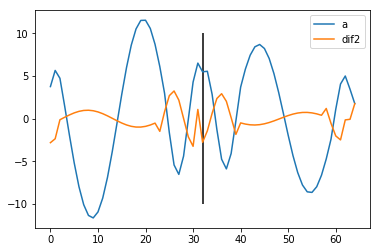

In [84]:
plt.plot(a.numpy(), label='a')
# plt.plot(roll.numpy(), label='roll')
# plt.plot(dif.numpy(), label='dif')
plt.plot(dif2.numpy(), label='dif2')
plt.vlines(src_x, -10, 10)
plt.legend()
plt.show()

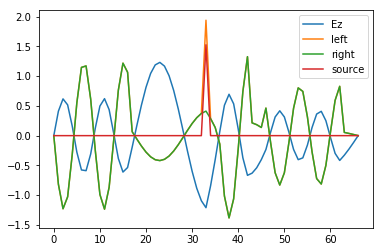

In [94]:
# sourcevals = []
# for i in pbar(range(1000)):

perms = perm_alternating_layers(s=65)
epsilons, src_x, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perms, omega=OMEGA_1550)

a = torch.cat([zero, torch.tensor(np.imag(Ez)[16:-16]), zero], dim=-1)
diffs = torch.cat([zero, tensor_diff(a, n=2, padding=None), zero], dim=-1)
# diffs = tensor_diff(a, n=2, cyclic=True)

ez = np.concatenate([[0], np.imag(Ez[16:-16]), [0]])

eps = epsilons[16:-16]
barrier = torch.tensor([-1e10]).double()
eps = torch.cat([barrier, torch.tensor(eps), barrier], dim=-1)

# print(a.shape, dif2.shape, ez.shape, eps.shape)

x = PIXEL_SIZE * (np.arange(eps.shape[0]) - src_x)
# Check wave equation terms match
left = SCALE * diffs.numpy() / PIXEL_SIZE**2
right = SCALE * -OMEGA**2 * MU0 * EPSILON0 * eps.numpy() * ez
source = left-right

plt.plot(0.1 * ez, label="Ez")
plt.plot(left, label="left")
plt.plot(right, label="right")

plt.plot(source, label="source")
plt.legend()
plt.show()

# sourcemax = np.max(source[1:-1])
# sourcevals.append(sourcemax)
    

In [173]:
class Perm1dDataset_test(Dataset):
    
    def __init__(self, hdf5_file, batch_name, kernel_sizes = []):
        
        data = load_batch(hdf5_file, batch_name)
        
        self.epsilons = data["epsilons"] 
        self.src = data["src"]
        self.Ez = data["Ez"]
                
        self.input_size = self.Ez[0].shape[0]
        output_size = self.input_size
        for kernel_size in kernel_sizes:
            stride = 1
            output_size = (output_size - kernel_size) / stride + 1
        self.output_size = int(output_size)
        
    def __len__(self):
        return len(self.epsilons)

    def __getitem__(self, i):
        epsilons = torch.tensor(self.epsilons[i])
        src_x = self.src[i]
        fields = torch.tensor(np.imag(self.Ez[i])) # TODO: change to real
        return epsilons.float(), fields.float()

class Perm1dDataset(Dataset):
    
    def __init__(self, epsilon_generator, kernel_sizes = [], N=10000, size=65, infinite_mode=False):
        self.size = size
        self.epsilon_generator = epsilon_generator
        self.epsilon_samples = []
        self.N = N
        self.infinite_mode = infinite_mode
        
    def __len__(self):
        if self.infinite_mode:
            return int(1e8)
        else:
            return int(self.N)

    def __getitem__(self, i):
        if i >= len(self.epsilon_samples) or self.infinite_mode:
            epsilons = torch.tensor(self.epsilon_generator())
            if not self.infinite_mode:
                self.epsilon_samples.append(epsilons)
            return epsilons, torch.empty_like(epsilons)
        else:
            epsilons = self.epsilon_samples[i]
            return epsilons, torch.empty_like(epsilons)

In [204]:
class MaxwellDense(nn.Module):
    
    def __init__(self, size=65, src_x=32, supervised=False, regularize_A_phi=True):
        super().__init__()
        
        self.size = size
        self.src_x = src_x
        self.supervised = supervised
        self.regularize_A_phi = regularize_A_phi

        self.layer_dims = [self.size, 128, 256, 256, 128, self.size]

        layers_amp = []
        layers_phi = []
        for i in range(len(self.layer_dims) - 1):
            layers_amp.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            layers_phi.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            
        self.layers_amp = nn.ModuleList(layers_amp)
        self.layers_phi = nn.ModuleList(layers_phi)
        
    def forward_amplitude_phase(self, x):
        A = x
        for i, layer in enumerate(self.layers_amp):
            A = layer(A)
            if i < len(self.layers_amp) - 1:
                A = nn.ReLU()(A)
                
        phi = x
        for i, layer in enumerate(self.layers_phi):
            phi = layer(phi)
            if i < len(self.layers_amp) - 1:
                phi = nn.ReLU()(phi)
        
        return A, phi
    
    def get_fields(self, epsilons, A_phi=None):
        # Get amplitude and phase vectors
        if A_phi is None:
            A, phi = self.forward_amplitude_phase(epsilons)
        else:
            A, phi = A_phi
            
        # Combine to form waveform
        x = (PIXEL_SIZE * (torch.arange(self.size, dtype=torch.float) - self.src_x))
        fields = A * torch.cos(OMEGA / C * torch.sqrt(epsilons) * x + phi)
        
        return fields
    
    def forward(self, epsilons):        
        # Compute Ez fields
        A, phi = self.forward_amplitude_phase(epsilons)
        fields = self.get_fields(epsilons, A_phi=(A, phi))
        
        if self.supervised:
            labels = torch.empty_like(fields)
            for i, perm in enumerate(epsilons.detach().numpy()):
                _, _, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perm, omega=OMEGA_1550)
                labels[i, :] = torch.tensor(np.imag(Ez[16:-16])).float()
            return fields - labels
        
        else:
            batch_size, _ = epsilons.shape

            # Add zero field amplitudes at edge points for resonator BC's
            zero = torch.zeros((batch_size, 1))
            E = torch.cat([zero, fields, zero], dim=-1)

            # Add first layer of cavity BC's
            barrier = torch.full((batch_size, 1), -1e10)
            eps = torch.cat([barrier, epsilons, barrier], dim=-1)
            
            # Compute Maxwell operator on fields
            diffs = tensor_diff(E, n=2, padding=None)
            curl_curl_E = (SCALE / PIXEL_SIZE**2) * torch.cat([zero, diffs, zero], dim=-1)
            epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

            # Compute free-current vector
            J = torch.zeros_like(E)
            J[:,self.src_x + 1] = 1.526814027933079

            out = curl_curl_E - epsilon_E - J
            
            # Penalize excessive variation in A/phi
            if self.regularize_A_phi:
                A_variation = torch.sum(torch.abs(tensor_diff(A)), -1, keepdim=True)
                phi_variation = torch.sum(torch.abs(tensor_diff(phi)), -1, keepdim=True)
                eps_variation = torch.sum(torch.abs(tensor_diff(epsilons)), -1, keepdim=True)
                factor = 1e-4 / (1 + eps_variation)
                out = torch.cat([out, factor*A_variation, factor*phi_variation], dim=-1)
            
            return out

In [ ]:
class MaxwellConv(nn.Module):
    
    def __init__(self, size=65, src_x=32, supervised=False, regularize_A_phi=True):
        super().__init__()
        
        self.size = size
        self.src_x = src_x
        self.supervised = supervised
        self.regularize_A_phi = regularize_A_phi

        self.layer_dims = [self.size, 128, 256, 256, 128, self.size]

        layers_amp = []
        layers_phi = []
        for i in range(len(self.layer_dims) - 1):
            layers_amp.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            layers_phi.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            
        self.layers_amp = nn.ModuleList(layers_amp)
        self.layers_phi = nn.ModuleList(layers_phi)
        
        
        
        
        self.input_channels = 1
        self.output_channels = 1
        
        self.conv_channels = [16, 16, 24, 32, 24]
        self.kernel_sizes = [7, 7, 7, 5, 3]
        
        output_size = self.size
        for kernel_size in self.kernel_sizes:
            stride = 1
            output_size = (output_size - kernel_size) / stride + 1
        self.output_size = int(output_size)

        layers = []
        
        in_channels = self.input_channels # number of input channels
        for out_channels, kernel_size in zip(self.conv_channels, self.kernel_sizes):
            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=0))
            in_channels = out_channels
        
        self.convolutions = nn.ModuleList(layers)
        self.conv_output_size = self.output_size * self.conv_channels[-1]
    
        self.hidden_size = 256
        self.dense1 = nn.Linear(self.conv_output_size, self.hidden_size)
        self.dense2 = nn.Linear(self.hidden_size, 1)
        
    def forward_amplitude_phase(self, x):
        A = x
        for i, layer in enumerate(self.layers_amp):
            A = layer(A)
            if i < len(self.layers_amp) - 1:
                A = nn.ReLU()(A)
                
        phi = x
        for i, layer in enumerate(self.layers_phi):
            phi = layer(phi)
            if i < len(self.layers_amp) - 1:
                phi = nn.ReLU()(phi)
        
        return A, phi
    
    def get_fields(self, epsilons, A_phi=None):
        # Get amplitude and phase vectors
        if A_phi is None:
            A, phi = self.forward_amplitude_phase(epsilons)
        else:
            A, phi = A_phi
            
        # Combine to form waveform
        x = (PIXEL_SIZE * (torch.arange(self.size, dtype=torch.float) - self.src_x))
        fields = A * torch.cos(OMEGA / C * torch.sqrt(epsilons) * x + phi)
        
        return fields
    
    def forward(self, epsilons):        
        # Compute Ez fields
        A, phi = self.forward_amplitude_phase(epsilons)
        fields = self.get_fields(epsilons, A_phi=(A, phi))
        
        if self.supervised:
            labels = torch.empty_like(fields)
            for i, perm in enumerate(epsilons.detach().numpy()):
                _, _, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perm, omega=OMEGA_1550)
                labels[i, :] = torch.tensor(np.imag(Ez[16:-16])).float()
            return fields - labels
        
        else:
            batch_size, _ = epsilons.shape

            # Add zero field amplitudes at edge points for resonator BC's
            zero = torch.zeros((batch_size, 1))
            E = torch.cat([zero, fields, zero], dim=-1)

            # Add first layer of cavity BC's
            barrier = torch.full((batch_size, 1), -1e10)
            eps = torch.cat([barrier, epsilons, barrier], dim=-1)
            
            # Compute Maxwell operator on fields
            diffs = tensor_diff(E, n=2, padding=None)
            curl_curl_E = (SCALE / PIXEL_SIZE**2) * torch.cat([zero, diffs, zero], dim=-1)
            epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

            # Compute free-current vector
            J = torch.zeros_like(E)
            J[:,self.src_x + 1] = 1.526814027933079

            out = curl_curl_E - epsilon_E - J
            
            # Penalize excessive variation in A/phi
            if self.regularize_A_phi:
                A_variation = torch.sum(torch.abs(tensor_diff(A)), -1, keepdim=True)
                phi_variation = torch.sum(torch.abs(tensor_diff(phi)), -1, keepdim=True)
                eps_variation = torch.sum(torch.abs(tensor_diff(epsilons)), -1, keepdim=True)
                factor = 1e-4 / (1 + eps_variation)
                out = torch.cat([out, factor*A_variation, factor*phi_variation], dim=-1)
            
            return out

In [205]:
def perm_generator_vacuum():
    return np.ones(65)

In [206]:
# Device configuration
device = torch.device('cpu')

# Create a model   
model = MaxwellDense(supervised=False).to(device)
# writer = SummaryWriter()

# Create data loaders
batch_size = 500

# train_data = Perm1dDataset(perm_generator_vacuum, N=1, infinite_mode=False)
train_data = Perm1dDataset(lambda: perm_alternating_layers(s=65), N=1e5, infinite_mode=False)
test_data = Perm1dDataset_test("datasets/test_1d_unsupervised.hdf5", "alternating_layers")
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [207]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.00001

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.1)
# losses = []

# Train the model
model.train()
total_step = len(train_loader)
epoch_iterator = pbar(range(num_epochs))
params = []

for epoch in epoch_iterator:
    
    SHOW_ITERATION_PROGRESS = True
    if SHOW_ITERATION_PROGRESS:
        train_loader = pbar(train_loader)
        
    for epsilons, _ in train_loader:
        
        epsilons = epsilons.float().to(device)
        
        # Forward pass
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        
        if SHOW_ITERATION_PROGRESS:
            train_loader.set_description("ℒ = {:.2e}".format(loss.item()), refresh=False)
    epoch_iterator.set_description("ℒ = {:.2e}".format(loss.item()), refresh=False)

# Save the model checkpoint
torch.save(model.state_dict(), 'model1d.ckpt')

In [159]:
model.load_state_dict(torch.load("model1d_nov28.ckpt"))

0.01210784912109375 4.00543212890625e-05 0.0033081285444234404


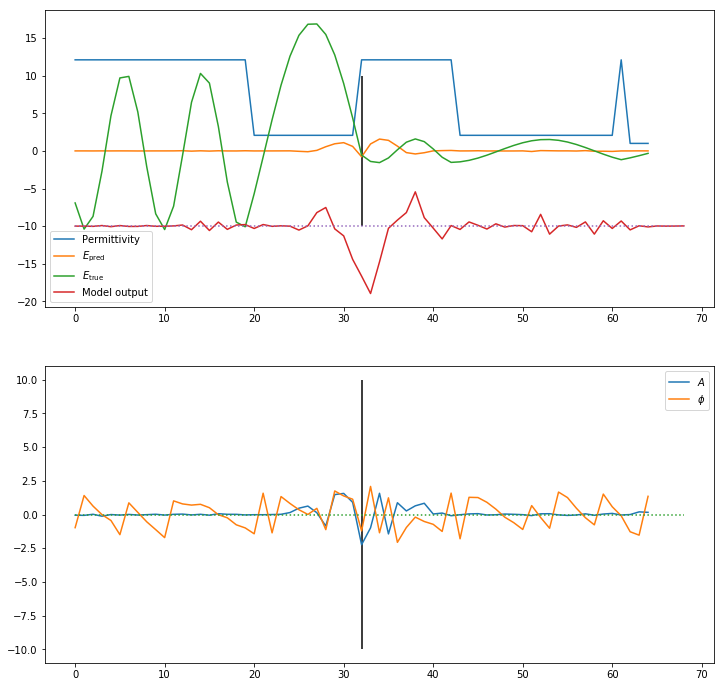

In [208]:
model.eval()

# perms = perm_generator_vacuum()
perms = perm_alternating_layers(s=65)
# perms = perm_random_number_alternating_layers(s=65)
# epsilons = train_loader.dataset[0][0]

start = time()
_, src_x, Hx, Hy, Ez = Cavity1D(cavity_buffer=16).solve(perms, omega=OMEGA_1550)
sim_time = time() - start

epsilons = torch.tensor([perms]).float()
start = time()
# fields = model.get_fields(epsilons)
# fields = model.get_field_amplitudes(epsilons)
network_time = time() - start

A, phi = model.forward_amplitude_phase(tensor_diff(epsilons))
fields = model.get_fields(epsilons, A_phi=(A, phi))
        

outputs = model(epsilons)[0].detach().numpy()

print(sim_time, network_time, network_time / sim_time)

f, ax = plt.subplots(2, 1, figsize=(12,12))
ax[0].plot(epsilons[0].detach().numpy(), label="Permittivity")
ax[0].plot(fields[0].detach().numpy(), label="$E_\mathrm{pred}$")
ax[0].plot(np.imag(Ez)[16:-16], label="$E_\mathrm{true}$")
ax[0].plot(-10 + 20*outputs, label="Model output")
ax[0].plot(-10 * np.ones(outputs.shape), linestyle=':')
ax[0].vlines(src_x, -10, 10)
ax[0].legend()

ax[1].plot(A[0].detach().numpy(), label="$A$")
ax[1].plot(phi[0].detach().numpy(), label="$\phi$")
ax[1].plot(np.zeros(outputs.shape), linestyle=':')
ax[1].vlines(src_x, -10, 10)
ax[1].legend()

plt.show()

In [169]:
Ez

array([-0.+3.07473627e-138j, -0.+1.26258037e-129j, -0.+5.18453956e-121j,
       -0.+2.12892986e-112j, -0.+8.74203444e-104j, -0.+3.58974562e-095j,
       -0.+1.47405889e-086j, -0.+6.05293478e-078j, -0.+2.48551939e-069j,
       -0.+1.02062997e-060j, -0.+4.19101752e-052j, -0.+1.72095945e-043j,
       -0.+7.06678367e-035j, -0.+2.90183662e-026j, -0.+1.19158250e-017j,
       -0.+4.89300070e-009j, -0.+2.00921512e+000j, -0.+3.01926784e+000j,
       -0.+2.52786912e+000j, -0.+7.79386606e-001j,  0.-1.35667701e+000j,
        0.-2.81807883e+000j,  0.-2.87807850e+000j,  0.-1.50683877e+000j,
        0.-7.29422958e-003j, -0.+1.49287140e+000j, -0.+2.86592152e+000j,
       -0.+3.99494320e+000j,  0.+4.78380214e+000j, -0.+5.16532830e+000j,
       -0.+5.10703538e+000j, -0.+4.61388692e+000j, -0.+3.72787368e+000j,
       -0.+2.52443822e+000j, -0.+1.10605106e+000j,  0.-4.06514508e-001j,
        0.-1.88446604e+000j,  0.-3.20195843e+000j,  0.-4.24680941e+000j,
        0.-4.93005165e+000j,  0.-5.19350822e+000j, 